In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime
import math

import statsmodels

## Získání dat
V tomto textu budeme různé způsoby predikce časových řad demonstrovat na teplotách naměřených v Klementinu. Data jsou k dispozici [zde](https://www.chmi.cz/historicka-data/pocasi/praha-klementinum#).  

Nejprve data načteme a ze sloupců pro den, měsíc a rok vyrobíme jeden sloupec obsahující celé datum.

In [2]:
klementinum_frame_raw = pd.read_excel("PKLM_pro_portal.xlsx", engine="openpyxl", sheet_name="data")
klementinum_frame_raw[["day", "month", "year", "temperature"]] = klementinum_frame_raw[["den", "měsíc", "rok", "T-AVG"]]
klementinum_frame_raw["date"] = pd.to_datetime(klementinum_frame_raw[["day", "month", "year"]])
klementinum_frame = klementinum_frame_raw[["date", "day", "month", "year", "temperature"]].copy()

In [3]:
klementinum_frame.head()

,date,day,month,year,temperature
0,1775-01-01,1,1,1775,-7.0
1,1775-01-02,2,1,1775,-2.2
2,1775-01-03,3,1,1775,-1.0
3,1775-01-04,4,1,1775,0.1
4,1775-01-05,5,1,1775,2.2


Pro velice letmé seznámení se s daty si necháme vykreslit závislost průměrné celoroční teploty na roku.

''

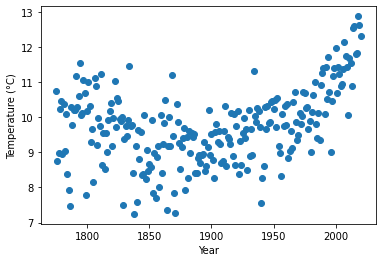

In [4]:
klementinum_avg_by_year = klementinum_frame.groupby("year").agg(avg_temp=("temperature", np.mean))
plt.scatter(klementinum_avg_by_year.index, klementinum_avg_by_year["avg_temp"])
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
;

Následně si vyrobíme trénovací a testovací množinu dat.

In [5]:
test_start_day = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")
test_end_day = datetime.datetime.strptime("2020-12-31", "%Y-%m-%d")

In [6]:
training_frame = klementinum_frame[
    (klementinum_frame["date"]<test_start_day)
]

testing_frame = klementinum_frame[
    (klementinum_frame["date"]>=test_start_day)
    & (klementinum_frame["date"]<=test_end_day)
]

## Konstanta
Člověk by měl při využívání technik strojového učení výstup oněch technik vždy srovnávat s nějakou baselinou, tj. s nějakým hodně naivním přístupem. Pak se totiž snadno a rychle pozná, pokud ML algoritmus (resp. jeho implementace) spektakulárně selže. V našem případě vezmeme jako baselinu konstantu - jednak hodnotu v posledním dni trénovací množiny (přeci jen je testovacím datům nejblíže), jednak průměrnou hodnotu spočítanou z dat celé trénovací množiny.

In [7]:
const_last_day = training_frame[training_frame["date"]==max(training_frame["date"])]["temperature"].values[0]
const_avg = np.mean(training_frame["temperature"])
print(f"Constant (last day): {const_last_day}")
print(f"Constant (average): {const_avg}")

Constant (last day): 10.3
Constant (average): 9.712700272663767


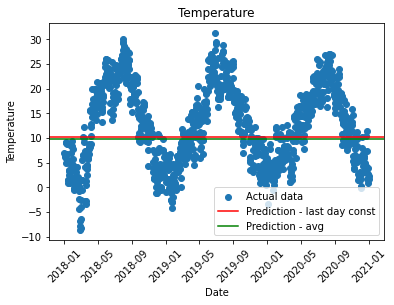

In [8]:
plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.axhline(y=const_last_day, color="r", linestyle="-")
plt.axhline(y=const_avg, color="g", linestyle="-")
plt.title("Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(["Actual data", "Prediction - last day const", "Prediction - avg"])
plt.xticks(rotation=45);

Z obrázků vidíme, že výsledky obou predikcí byly hodně podobné - a hodně mimo. Kdyby ale v teplotách nebyla jasná závislost na ročním období, jak bychom poznali, která z predikcí je lepší? Možná by to šlo rozlišit okometricky, nicméně vhodnější  bude spočítání RMSE (root mean square error).

In [9]:
def get_rmse_for_const(numbers_serie, constant):
    return math.sqrt(
        sum(
            (numbers_serie-constant)*(numbers_serie-constant)
        )/len(testing_frame)
    )

rmse_last_day = get_rmse_for_const(testing_frame["temperature"], const_last_day)
rmse_avg = get_rmse_for_const(testing_frame["temperature"], const_avg)
print(f"RMSE (last day): {round(rmse_last_day):,}")
print(f"RMSE (avg): {round(rmse_avg):,}")

RMSE (last day): 8
RMSE (avg): 8


Na takovýchto datech je to asi jedno, nicméně... nebylo by lepší spíše než výše uvedené extrémy brát v  uváhu posledních n hodnot? Takto vytvořené časové okno se označuje jako "sliding window" a vypočtený průměr jako "moving average". Samozřejmě problematickým bodem je určení velikost okna...

Constant (moving average): 5.140000000000001
RMSE (moving average): 11


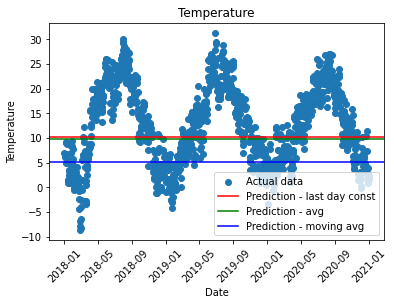

In [10]:
sliding_window = 10
const_mov_avg = np.mean(training_frame.tail(sliding_window)["temperature"])
rmse_mov_avg = get_rmse_for_const(testing_frame["temperature"], const_mov_avg)
print(f"Constant (moving average): {const_mov_avg}")
print(f"RMSE (moving average): {round(rmse_mov_avg):,}")

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.axhline(y=const_last_day, color="r", linestyle="-")
plt.axhline(y=const_avg, color="g", linestyle="-")
plt.axhline(y=const_mov_avg, color="b", linestyle="-")
plt.title("Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(["Actual data", "Prediction - last day const", "Prediction - avg", "Prediction - moving avg"])
plt.xticks(rotation=45);

Vidíme, že moving average od předešlých predikcí odskočil. Co se mnohaletého celoročního průměru týče, tak to překvapení není - přeci jen sliding window obsahovalo pouze konec prosince. U predikce z posledního dne fakticky za odskok nemůže způsob výpočtu moving average, ale skutečnost, že 31. prosinec roku 2017 byl v porovnání s předešlými dny překvapivě teplý.  
Drobným vylepšením předchozího přístupu je použití vah - pak mluvíme o "weighted moving average". Samozřejmě krom problému s velikostí okna nám zde pak vyvstává i otázka velikosti vah. Z hlediska algoritmu jsme omezeni jen tím, že celkový součet vah musí být roven 1.

Constant (weighted moving average): 5.145
RMSE (weighted moving average): 11


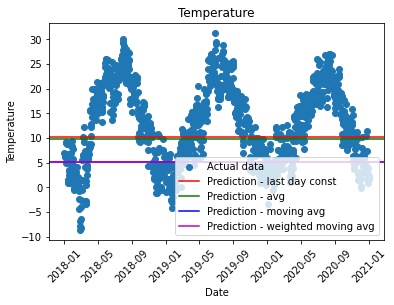

In [11]:
sliding_window = 10
weight_list = [0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.15, 0.15, 0.2]
const_weigh_mov_avg = np.average(training_frame.tail(sliding_window)["temperature"], weights=weight_list)
rmse_weigh_mov_avg = get_rmse_for_const(testing_frame["temperature"], const_mov_avg)
print(f"Constant (weighted moving average): {const_weigh_mov_avg}")
print(f"RMSE (weighted moving average): {round(rmse_weigh_mov_avg):,}")

legend_list = [
    "Actual data", "Prediction - last day const", 
    "Prediction - avg", "Prediction - moving avg",
    "Prediction - weighted moving avg"
]

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.axhline(y=const_last_day, color="r", linestyle="-")
plt.axhline(y=const_avg, color="g", linestyle="-")
plt.axhline(y=const_mov_avg, color="b", linestyle="-")
plt.axhline(y=const_weigh_mov_avg, color="m", linestyle="-")
plt.title("Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(legend_list)
plt.xticks(rotation=45);

## Exponential smoothing
Poznamenejme úvodem, že při psaní kapitol týkajících se všelijakých forem smoothingu bylo extenzivně čerpáno [odtud](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/).  

Když se podíváme na metody popsané výše, může nás napadnout zkusit je všechny sloučit do jedné. Výsledkem by byl vážený průměr beroucí v úvahu celou časovou řadu, avšak používající váhy, které s rostoucí vzdáleností od koncového bodu (dejme tomu současnosti) klesají. Jenže jak ony váhy určit?  
V nadpisu této kapitoly vidíme "Exponential smoothing" neboli exponenciální vyhlazení. Jak název napovídá, jedná se o postup, jak vyhladit příliš zubaté grafy, aby se z nich daly vyčíst užitečné informace. Předpis vypadá následovně:

$ \hat{L}_x = \alpha L_x + (1-\alpha)\hat{L}_{x-1}$

Zde se snažíme spočítat "vyhlazenou" (vyhlazení znázorňuje stříška) y-ovou souřdnici bodu - veličiny L - pro hodnotu x. K tomu potřebujeme jednak původní hodnotu y-ové souřadnice tohoto bodu, jednak vyhlazenou souřadnici pro předchozí hodnotu x. Alfa tu zastupuje tzv. smoothing faktor, který říká, jak moc silné (či spíše slabé - vyhlazení je pro $\alpha$ = 1 vypnuté) vyhlazování je.  
To je sice všechno pěkné, ale jak nám to pomůže s predikcí časové řady? Inu, výše uvedený předpis můžeme přepsat na

$ \hat{y}_{t+1} = \alpha y_t + (1-\alpha)\hat{y_{t}}$

Asi pořád ještě nemusí být jasné, proč by zrovna tento předpis měl být k něčemu užitečný. To ale zjistíme, když se pokusíme dobrat významu slova "exponenciální" v názvu algoritmu. Rovnice, kterou jsme napsali, je totiž rekurzivní. Tj. můžeme do ní dále dosazovat:

$ \hat{y}_{t+1} = \alpha y_t + (1-\alpha)\hat{y_{t}} = \alpha y_t + (1-\alpha)(\alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}}) =  \alpha y_t + \alpha (1-\alpha)y_{t-1} + (1-\alpha)^2 (\alpha y_{t-2} + (1-\alpha)\hat{y_{t-2}})$

Vidíme tedy, že výsledná hodnota závisí na všech předchozích hodnotách, ale tyto hodnoty mají na sebe napojeny čím dál tím menší váhy.  
Zkusme ještě dokázat, že suma vah dává jedničku. Přepišme výše uvedený vztah na

$ \hat{y}_{t+1} =  \alpha [y_t + (1-\alpha)y_{t-1} + (1-\alpha)^2 y_{t-2}] + (1-\alpha)^3 \hat{y}_{t-2} $

Druhý člen je kvůli největší mocnině váhy (pro kterou platí $0 < \alpha < 1$) v celém výrazu ze všech částí vzorce nejmenší a tak ho můžeme pominout. Váhy v prvním členu v hranaté závorce tvoří de facto nekonečnou (fakticky má víc než zde ukázané jednotky členů) geometrickou řadu. Pro součet nekonečné qeometrické řady s kvocientem q (|q|<1) platí

$ 1 + q + q^2 + q^3 + ... = \frac {1}{1-q} $

V našem případě čini kvocient q = 1 - $\alpha$. Tj. ve jmenovateli máme samotnou alfu, která se vykrátí s alfou stojící před sumou (aka před hranatou závorkou). Výsledkem je tak jednička alias to, co jsme požadovali. 

Použití exponential smoothingu (spávněji single exponential smoothingu) předpokládá, že v datech není žádný výrazný trend, natož pak sezóní (týdenní, měsíční, roční) výkyvy. Jinak by přeci jen - s vyhlazením nebo bez - nemohla hodnota veličiny v čase t+1 záviset z velké části na hodnotě veličiny v čase t.  
Metoda poskytuje predikci pouze jednoho bodu od konce trénovacích dat. To by se pravda dalo říci i o předchozích p59stupech. Zde však už to jedno číslo přes celou testovací časovou řadu neprotáhneme. Důvod bude jasný, až začneme diskutovat další algoritmy, které ze single exponential smoothingu vycházejí a které se dokáží dívat dále do budoucnosti.

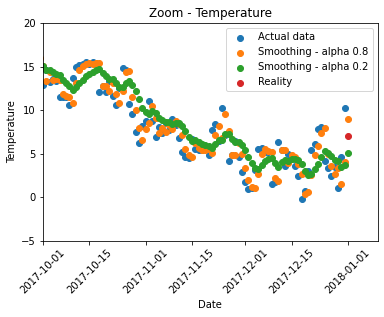

In [12]:
def get_exp_smooth_prediction(time_serie, alpha):
    first_point = time_serie[0]
    smoothed_serie = [first_point]
    
    for elem_index in range(1, len(time_serie)):
        smoothed_point = alpha*time_serie[elem_index] + (1-alpha)*smoothed_serie[elem_index-1]
        smoothed_serie.append(smoothed_point)
    
    return smoothed_serie

date_list_for_smoothed = training_frame["date"] + pd.DateOffset(days=1)
smoothed_a08 = get_exp_smooth_prediction(training_frame["temperature"].to_list(), 0.8)
smoothed_a02 = get_exp_smooth_prediction(training_frame["temperature"].to_list(), 0.2)

x_lim_left = datetime.datetime.strptime("2017-10-01", "%Y-%m-%d").date()
x_lim_right = datetime.datetime.strptime("2018-01-10", "%Y-%m-%d").date()

legend_list = [
    "Actual data", 
    "Smoothing - alpha 0.8", 
    "Smoothing - alpha 0.2",
    "Reality"
]

plt.scatter(training_frame["date"], training_frame["temperature"])
plt.scatter(date_list_for_smoothed,smoothed_a08)
plt.scatter(date_list_for_smoothed,smoothed_a02)
plt.scatter(testing_frame.iloc[0]["date"], testing_frame.iloc[0]["temperature"])
plt.title("Zoom - Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xlim((x_lim_left, x_lim_right))
plt.ylim((-5, 20))
plt.legend(legend_list)
plt.xticks(rotation=45);

## Double exponential smoothing
Jak již bylo uvedeno, výše diskutovaný single exponential smoothing počítá s tím, že v datech neexistuje žádný trend. Jinými slovy se hodí na "predikci" zašumněné, na čase nezávislé horizontální čáry. Oproti tomu double exponential smoothing už s existencí trendu pracuje.  
Zaveďme si napřed několik termínů. Pod levelem/baselinou/interceptem si představíme právě onu konstantní netrendovou složku časové řady. Budeme ji označovat písmenem **l**. Trend/slope/sklon zase označíme písmenem **b**. Obecně pro trend platí, že  
$b = \frac{\Delta y}{\Delta x}$  

Nicméně v časových řadách, kde se na ose x vyskytují jednotlivé dny, bude jejich vzdálenost jednotková. Tudíž se nám výše uvedený vzoreček redukuje na  

$b = \Delta y = y_{t} - y_{t-1}$   

Pro predikci nyní platí (s předpokladem jednotkového kroku v čase)  

$\hat{y}_{t+1} = l_t + b_t$  

Jak pro baselinu, tak pro trend použijeme exponential smoothing předpis (proto se v názvu algoritmu vzskztuje slovo "double"). Co se baseliny týče, tak u ní si musíme uvědomit, že se jedná o "vyhlazenou" veličinu. Tj. v prvním členu máme nevyhlazenou hodnotu **y** v čase **t**, v druhém členu už vyhlazenou hodnotu v čase **t-1**.  

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$  

U trendu si zase jako nevyhlazenou hodnotu vezmeme rozdíl baselin:  

$b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}$  

Vyvstává otázka, jak moc dopředu lze s pomocí double exponential smoothingu koukat dopředu. Lze si [přečíst](https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/), že spolehlivé jsou dva kroky do budoucnosti. Popravdě mne nenapadá, čím by se takové tvrzení dalo obhájit.

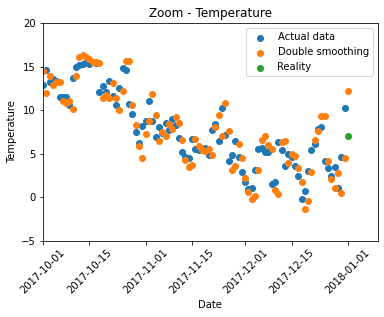

In [13]:
def get_double_exp_smooth_prediction(time_serie, alpha, beta):
    first_point = time_serie[0]
    smoothed_serie = [first_point]
    
    for elem_index in range(1, len(time_serie)):
        #second point of time serie
        if elem_index == 1:
            current_baseline = time_serie[1]
            current_trend = time_serie[1] - time_serie[0]
        #prediction
        if elem_index >= len(time_serie):
            old_timepoint = smoothed_serie[-1]
        else:
            old_timepoint = time_serie[elem_index]

        old_baseline = current_baseline
        old_trend = current_trend

        current_baseline = alpha*old_timepoint + (1-alpha)*(old_baseline + old_trend)
        current_trend = beta*(current_baseline - old_baseline) + (1-beta)*old_trend
        
        smoothed_point = current_baseline + current_trend
        smoothed_serie.append(smoothed_point)
    
    return smoothed_serie


date_list_for_smoothed = training_frame["date"] + pd.DateOffset(days=1)

smoothed_temperature = get_double_exp_smooth_prediction(training_frame["temperature"].to_list(), 0.8, 0.5)

x_lim_left = datetime.datetime.strptime("2017-10-01", "%Y-%m-%d").date()
x_lim_right = datetime.datetime.strptime("2018-01-10", "%Y-%m-%d").date()

legend_list = [
    "Actual data", 
    "Double smoothing", 
    "Reality"
]

plt.scatter(training_frame["date"], training_frame["temperature"])
plt.scatter(date_list_for_smoothed, smoothed_temperature)
plt.scatter(testing_frame.iloc[0]["date"], testing_frame.iloc[0]["temperature"])
plt.title("Zoom - Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xlim((x_lim_left, x_lim_right))
plt.ylim((-5, 20))
plt.legend(legend_list)
plt.xticks(rotation=45);

## Triple exponential smoothoing (alias Holt-Winters)
Jedná se o rozšíření alogritmu z předchozí kapitoly o prvek sezónnosti. Sezónností myslíme takový příspěvek do časové řady, který se ve stejné velikosti v časové řadě pravidelně opakuje. Předpis pro Holt-Wintersovu metodu vypadá takto:  

$l_t = \alpha (y_{t}-s_{t-L})+(1-\alpha)(l_{t-1} + b_{t-1})$  
$b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}$  
$s_t = \gamma (y_t - l_t) + (1 - \gamma)s_{t-L}$  
$\hat{y}_{t+m} = l_t + mb_t + s_{t-L+1+(m-1)modL}$  

Vidíme, že pro sezónnost **s** platí obdobné vztahy jako pro trend **b** a baselinu **l**. U baseliny si všimněme, že se u jejího prvního členu odečítá od "měřených" dat **y** vliv sezónnosti. Podobně u vzorce pro sezónnost odečítáme v prvním členu od měřených dat baselinu.  
V některých rovnicích se vyskytuje v indexech písmeno **L**. To zastupuje délku (periodu) sezóny. A právě tato sezónnost je to, co teoreticky dovoluje provádět predikce do libovolně vzdálené budoucnosti. Index predikovaného času od konce trénovacích dat znázorňuje písmeno **m**. Tj. první hodnota za trénovacímí daty má **m = 1**.  
Predikci v čase **t**+**m** skládáme ze tří členů. Prvním je baselina. V rovnici se u ní sice objevuje index **t**, nicméně teoreticky by se mělo jednat o sice zašuměnou, ale reálně na čase nezávislou konstantu. Tudíž u ní její protáhnutí do budoucnosti nevadí. Druhým členem je trend v čase **t** přenásobený počtem kroků od času **t**. Zde totiž předpokládáme, že trend se od posledního bodu trénovací množiny nezměnil a tak po dobu **m** časových jednotek veličina například monotónně rostla. Nakonec tu máme sezonní člen s jeho dosti divokým indexem. Ten vypadá tak jak vypadá kvůli tomu, abychom se nesnažili skrze index přistoupit k neznáme veličině. Musíme totiž myslet na to, že u $s_x$ pro **x** > **t** hodnoty sezónnosti neznáme. Proto se od času **t** odečítá celá perioda **L**. Modulo operace pak zajišťuje, abycho se nad **t** nedostali. Výsledek modula totiž může být maximálně **L-1**, což se požere s předcházejícím **-L+1** a tak v indexu zbude **t**.    

Pro reálný výpočet si budeme muset zadefinovat iniciální hodnoty jednotlivých veličin. U baseliny se bude stejně jako u jednodušších variant smoothingu jednat o první bod trénovacích dat. U trendu si ale tentokrát nevystačíme s odečitáním prvních dvou bodů trénovacích dat od sebe. Musíme totiž z trendu dostat vliv sezónnosti. To zrealizujeme tak, že od prvního bodu druhé periody odečteme první bod první periody (tj. $y_{L+1}-y_1$). Tak dostaneme růst za celou jednu sezónu. Abychom měli růst za jednu časovou jednotku, musíme výše uvedený rozdíl podělit periodou L. Abychom potlaičili šum, uděláme stejnou operaci nejen pro první body, ale též pro body druhé, třetí až L-té. Výsledky pak sečteme a opět v rámci normalizace podělíme periodou alias počtem členů. Celkově tedy platí  

$b_0 = \frac{1}{L}(\frac{y_{L+1}-y_1}{L} + \frac{y_{L+2}-y_2}{L} + ... + \frac{y_{L+L}-y_L}{L})$  

V pythoním kódu vypadá takováto operace následovně:

In [14]:
def get_initial_trend_value(time_serie, season_length):
    sum_part = 0
    for season_index in range(season_length):
        sum_part += (time_serie[season_index+season_length] - time_serie[season_index])/season_length
    return sum_part/season_length

Poněkud složitěji se musí inicializovat sezónnost:
 - nejprve se pro každou sezónu spočítá její artimetický průměr
 - pak se každý z bodu časové řady vydělí oním průměrem pro sezónu, do které patří (tj. hodnoty bodů se nanormují, čímž se omezí vliv trendu)
 - nakonec se sezóní člen vezme jako průměr všech bodů z předcházejícího kroku, které do něj spadají (tj. například tu budou hodnoty za první den každého měsíce, které každý budou poděleny proměrnou hodnotou svého měsíce)
 
 

In [15]:
def get_initial_seasonal_components(time_serie, season_length):
    seasonal_components = {}
    seasons_averages = []
    seasons_count = int(len(time_serie)/season_length)
    for season_index in range(seasons_count):
        season_start_index = season_length*season_index
        next_season_start_index = season_length*season_index+season_length
        seasons_averages.append(sum(time_serie[season_start_index:next_season_start_index])/season_length)
    for season_elem_index in range(season_length):
        sum_one_season_elem = 0
        for season_index in range(seasons_count):
            sum_one_season_elem += time_serie[season_index*season_length + season_elem_index]/seasons_averages[season_index]
        seasonal_components[season_elem_index] = sum_one_season_elem/seasons_count
    return seasonal_components

Pak už můžeme napsat kód i pro samotnou Holt-Wintersovu metodu:

In [16]:
def get_triple_exp_smooth_prediction(time_serie, alpha, beta, gamma, season_length, forecast_length):
    smoothing_result = []
    seasonal_components = get_initial_seasonal_components(time_serie, season_length)
    for time_point_index in range(len(time_serie) + forecast_length):
        #initialization
        if time_point_index == 0:
            baseline = time_serie[0]
            trend = get_initial_trend_value(time_serie, season_length)
            smoothing_result.append(time_serie[0])
            continue
        #forecast
        if time_point_index >= len(time_serie):
            m = time_point_index - len(time_serie) + 1
            smoothing_result.append(baseline + m*trend + seasonal_components[time_point_index%season_length])
        else:
            time_point = time_serie[time_point_index]
            old_baseline = baseline
            old_trend = trend
            baseline = alpha*(time_point-seasonal_components[time_point_index%season_length]) + (1-alpha)*(old_baseline+old_trend)
            trend = beta * (baseline-old_baseline) + (1-beta)*old_trend
            seasonal_components[time_point_index%season_length] = gamma*(time_point-baseline) + (1-gamma)*seasonal_components[time_point_index%season_length]
            smoothing_result.append(baseline + trend + seasonal_components[time_point_index%season_length])
    return smoothing_result

Napočítejme predikci:

In [17]:
date_list_for_smoothed = training_frame["date"].to_list() + testing_frame["date"].to_list()

pred_length = len(testing_frame)
smoothed_temperature = get_triple_exp_smooth_prediction(
    training_frame["temperature"].to_list(), 
    0.8, 0.15, 0.8, 365, pred_length
)

A zobrazme ji:

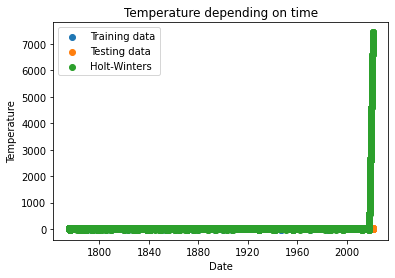

In [18]:
legend_list = [
    "Training data", 
    "Testing data", 
    "Holt-Winters"
]

plt.scatter(training_frame["date"], training_frame["temperature"])
plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(date_list_for_smoothed,smoothed_temperature)
plt.legend(legend_list)
plt.title("Temperature depending on time")
plt.xlabel("Date")
plt.ylabel("Temperature");

Vidíme, že predikce dosti znatelně od reality ulétla. Jelikož je úlet monotóní, je zjevné, že problém není v baselině ani v sezónosti, ale v trendu. Zkrátka koeficient beta má nevhodnou velikost. Ono ostatně ani není divu - všechny koeficinety jsme zvolili náhodně. Správně bychom je měli určit nafitování rovnic na trénovací data. Samozřejmě pro různé časové řady takto nabydou parametry různé velikosti.  
Nicméně asi nemá cenu, abychom se optimalizaci parametrů snažili přidat do kódu uvedeného výše a objevovali tak kolo. Holt-Wintersova metoda je totiž i s příslušenstvím již dodána v balíčku **statsmodels** jako **ExponentialSmoothing**. Tento objekt musíme napřed nafitovat (zavolat nad ním metodu **fit**) a predikci následně realizujeme metodou **forecast**. Do ní jako parametr uvedeme, kolik bodů do budoucna vlastně predikovat chceme. Do ExponentialSmoothing musíme krom dat na trénování vložit i to, zda trend a sezónost budou aditivní (tj. $trend = y_t - y_{t-1}$) či multiplikativní ($trend = y_t / y_{t-1}$). BACHA - pokud tyto parametry v konstruktoru objektu neuvedeme, bude to Pyothon interpretovat tak, že trend a/nebo sezónost vůbec nechceme.

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

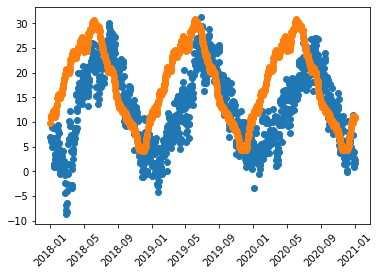

In [20]:
fitted_temperature = ExponentialSmoothing(
    training_frame["temperature"],
    seasonal_periods = 365,
    trend="add",
    seasonal="add",
    damped_trend=True
).fit()


pred_length = len(testing_frame)
prediction_temperature = fitted_temperature.forecast(pred_length)

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(testing_frame["date"], prediction_temperature)
plt.xticks(rotation=45);

Vidíme, že ačkoli je obecně tvar predikce v pořádku, je na časové ose poněkud posunuta. Důvodem je zvolená perioda. 365 dní totiž nereflektuje existenci přestupných roků. Sice se to nezdá, ale v takto dlouhých trénovacích datech může právě tento parametr napáchat solidní paseku. To zřetelně uvidíme, když periodu nastavíme na 366 dní:

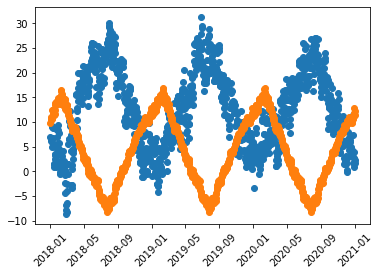

In [44]:
fitted_temperature = ExponentialSmoothing(
    training_frame["temperature"],
    seasonal_periods = 366,
    trend="add",
    seasonal="add",
    damped_trend=True
).fit()


pred_length = len(testing_frame)
prediction_temperature = fitted_temperature.forecast(pred_length)

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(testing_frame["date"], prediction_temperature)
plt.xticks(rotation=45);

Při zkrácení trénovacích dat už je predikce rozumnější, byť je zase poněkud mimo baselina.

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


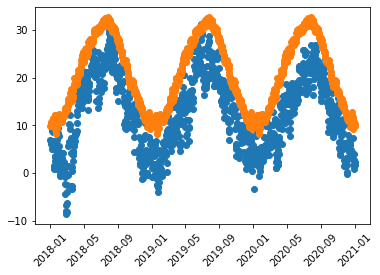

In [48]:
short_start_day = datetime.datetime.strptime("2001-01-01", "%Y-%m-%d")

short_training_frame = klementinum_frame[
    (klementinum_frame["date"]>=short_start_day)
    & (klementinum_frame["date"]<test_start_day)
]

fitted_temperature = ExponentialSmoothing(
    short_training_frame["temperature"],
    seasonal_periods = 365,
    trend="add",
    seasonal="add",
    damped_trend=True
).fit()


pred_length = len(testing_frame)
prediction_temperature = fitted_temperature.forecast(pred_length)

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(testing_frame["date"], prediction_temperature)
plt.xticks(rotation=45);